# Try the interpolation on synthetic data

In [1]:
import xarray as xr
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D, vector3d_jacobian
from vector3d.utils import plot_data, combinations, sample_from_grid, longitude_shift

Crop the synthetic data to a smaller region focused around the fault system.

In [2]:
data = xr.open_dataset('../../data/synthetic-san-andreas-2017.nc')
region = [-123, -115, 32, 40]
data = data.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))
data

<xarray.Dataset>
Dimensions:         (latitude: 133, longitude: 133)
Coordinates:
  * longitude       (longitude) float64 -123.0 -122.9 -122.9 -122.8 -122.7 ...
  * latitude        (latitude) float64 32.02 32.08 32.14 32.2 32.26 32.32 ...
Data variables:
    east_velocity   (latitude, longitude) float32 ...
    north_velocity  (latitude, longitude) float32 ...
    up_velocity     (latitude, longitude) float32 ...

In [3]:
data['up_velocity'] *= -1

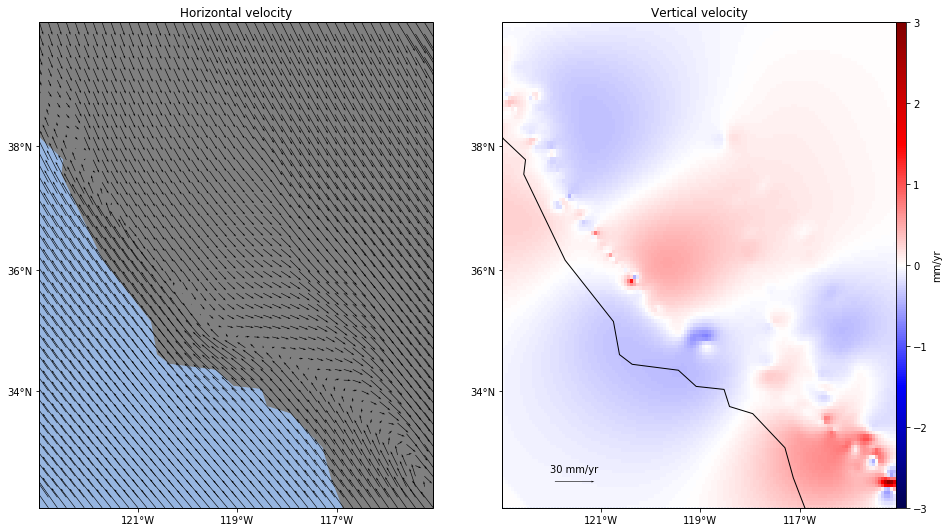

In [4]:
fig, axes = plot_data(data, every=3)

Setup a map projection.

In [5]:
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

Setup a reduced version of the data that we'll use in the actual interpolation.

In [6]:
spacing = 0.15
blockmean = vd.BlockReduce(np.mean, region=region, spacing=spacing, 
                           center_coordinates=True)
block_coords, block_data = blockmean.filter(np.meshgrid(data.longitude, data.latitude),
                                            (data.east_velocity.values, 
                                             data.north_velocity.values, 
                                             data.up_velocity.values))
reduced = pd.DataFrame({'east_velocity': block_data[0], 'north_velocity': block_data[1], 
                        'up_velocity': block_data[2], 'latitude': block_coords[1], 
                        'longitude': block_coords[0]})
reduced.head()

,east_velocity,north_velocity,up_velocity,latitude,longitude
0,-18.706850,22.654358,0.007421,32.075472,-122.924528
1,-18.701962,22.695793,0.011252,32.075472,-122.773585
2,-16.695988,19.974449,-0.007408,32.075472,-122.622642
3,-12.845934,14.632750,-0.046828,32.075472,-122.471698
4,-12.359818,13.882936,-0.050965,32.075472,-122.320755


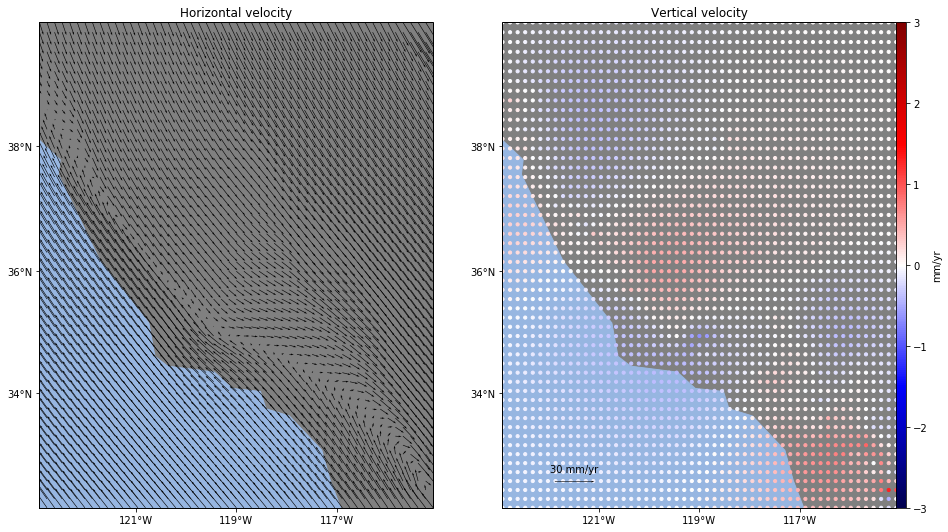

In [7]:
fig, axes = plot_data(reduced, every=1)

## Sample the synthetic data

Take the samples as the nearest neighbors of the real data points.

In [8]:
gpsdata = vd.datasets.fetch_california_gps()
gpsdata['longitude'] = longitude_shift(gpsdata.longitude, allpositive=False)
gpsdata = gpsdata[vd.inside((gpsdata.longitude, gpsdata.latitude), region)]
gpsdata.head()

,latitude,longitude,height,velocity_north,velocity_east,velocity_up,std_north,std_east,std_up
0,34.116409,-117.093196,762.11978,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
1,34.116409,-117.093196,762.10883,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
2,34.116409,-117.093195,762.09364,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
3,34.116409,-117.093195,762.09073,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
4,34.116409,-117.093195,762.07699,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053


In [9]:
sample = sample_from_grid(data, dict(longitude=gpsdata.longitude, latitude=gpsdata.latitude))
sample.head()

,east_velocity,north_velocity,up_velocity,longitude,latitude
0,1.301804,2.155317,0.07127,-117.096312,34.1225
1,1.301804,2.155317,0.07127,-117.096312,34.1225
2,1.301804,2.155317,0.07127,-117.096312,34.1225
3,1.301804,2.155317,0.07127,-117.096312,34.1225
4,1.301804,2.155317,0.07127,-117.096312,34.1225


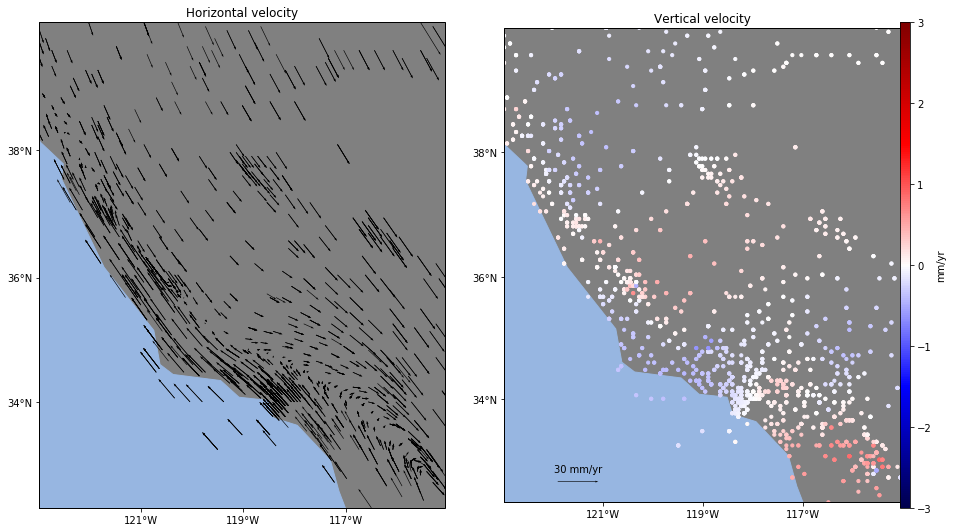

In [10]:
fig, axes = plot_data(sample, every=1)

## Simple gridding

In [11]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=1000, poisson=0.5))
])
chain.fit(proj(sample.longitude.values, sample.latitude.values), 
          (sample.east_velocity, sample.north_velocity, sample.up_velocity))

Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f4fe094ee18>, region=None,
      spacing=15000.0)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=None, depth=1000, flip_vertical=False, fudge=1e-05,
     poisson=0.5, region=None, shape=None, spacing=None))])

In [12]:
score = chain.score(proj(reduced.longitude.values, reduced.latitude.values), 
                    (reduced.east_velocity, reduced.north_velocity, reduced.up_velocity))
print("R2 score:", score)

R2 score: 0.5840163842173002


In [13]:
grid = chain.grid(region=region, spacing=spacing, projection=proj,
                  dims=['latitude', 'longitude'], 
                  data_names=['east_velocity', 'north_velocity', 'up_velocity'])
grid

<xarray.Dataset>
Dimensions:         (latitude: 54, longitude: 54)
Coordinates:
  * longitude       (longitude) float64 -123.0 -122.8 -122.7 -122.5 -122.4 ...
  * latitude        (latitude) float64 32.0 32.15 32.3 32.45 32.6 32.75 ...
Data variables:
    east_velocity   (latitude, longitude) float64 -27.61 -27.1 -26.6 -26.1 ...
    north_velocity  (latitude, longitude) float64 31.85 31.31 30.78 30.24 ...
    up_velocity     (latitude, longitude) float64 -0.06088 -0.05739 -0.05391 ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...

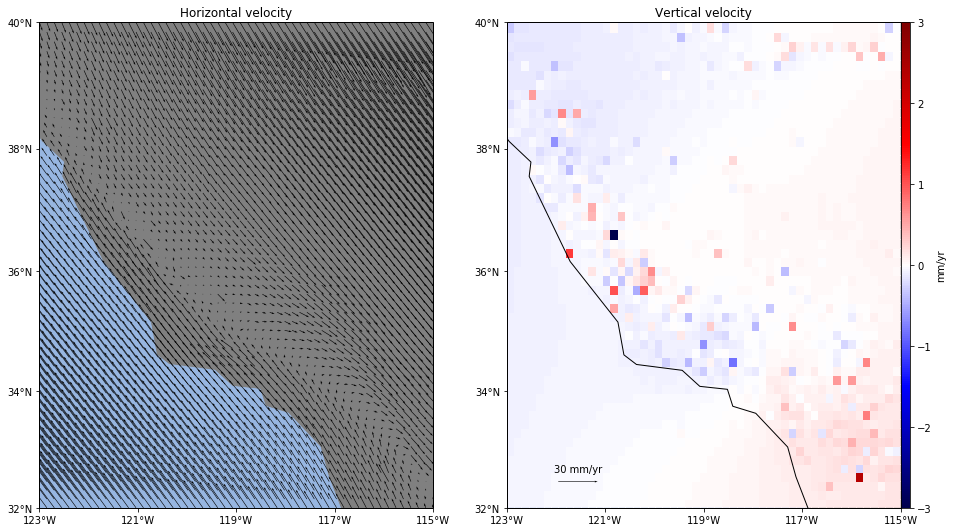

In [14]:
fig, axes = plot_data(grid, every=1)

In [15]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(reduced.longitude.values, reduced.latitude.values))
    res = reduced.copy()    
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    for pred, name in zip(predicted, names):
        res[name] = reduced[name] - pred
    return res

In [16]:
residuals = make_residuals(chain)
residuals.describe()

,east_velocity,north_velocity,up_velocity,latitude,longitude
count,2809.000000,2809.000000,2809.000000,2809.000000,2809.000000
mean,-0.226288,-0.277088,-0.001026,36.000000,-119.000000
std,4.421402,4.815657,0.198008,2.309401,2.309401
min,-14.598654,-15.219178,-1.571195,32.075472,-122.924528
25%,-2.611103,-2.899853,-0.114925,34.037736,-120.962264
50%,-0.123138,-0.243352,-0.011475,36.000000,-119.000000
75%,2.347758,2.263665,0.090476,37.962264,-117.037736
max,12.821289,14.039076,2.090027,39.924528,-115.075472


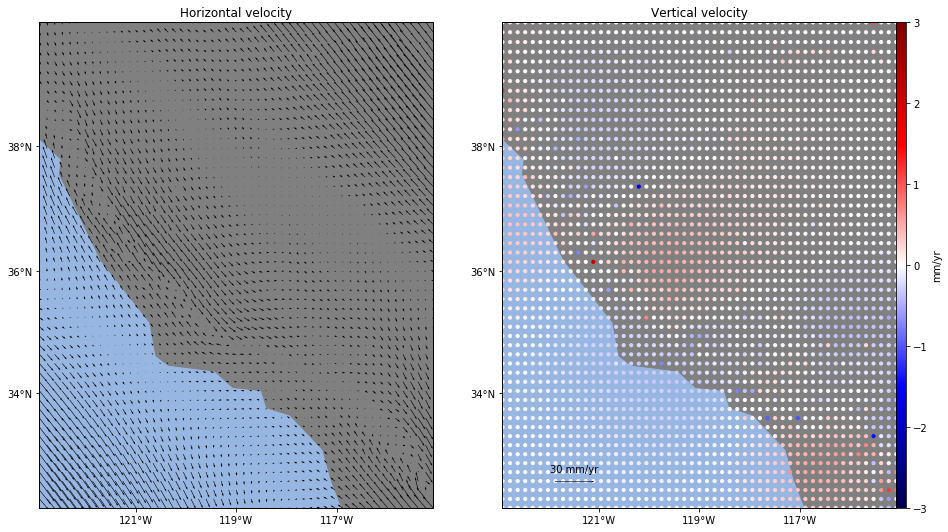

In [17]:
fig, axes = plot_data(residuals, every=1)

## Cross-validated

In [18]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36703 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.70 GB


In [19]:
def fit_score(estimator, fit_args, score_args):
    "Fit and score an estimator on the given arguments"
    return estimator.fit(*fit_args).score(*score_args)

In [20]:
%%time
proj_region = vd.project_region(region, proj)
fit_args = (proj(sample.longitude.values, sample.latitude.values),
            (sample.east_velocity, sample.north_velocity, sample.up_velocity))
score_args = (proj(reduced.longitude.values, reduced.latitude.values), 
              (reduced.east_velocity, reduced.north_velocity, reduced.up_velocity))

param_grid = combinations(
    spacing=[spacing*100e3*factor for factor in [3, 3.5, 4]],
    damping=[10**i for i in range(-10, 10, 2)],
    depth=[1e3, 10e3, 100e3],
    poisson=[-1, 0, 0.5],
)
print("spacings:", set(i['spacing'] for i in param_grid))

chains = []
scores = []
for params in param_grid:
    chain = vd.Chain([
        ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
        ('trend', vd.VectorTrend(1)),
        ('spline', Vector3D(region=proj_region, **params))
    ])
    chains.append(chain)
    scores.append(client.submit(fit_score, chain, fit_args, score_args))
best = client.submit(np.argmax, scores).result()
print("\nBest score:", scores[best].result())
chain = chains[best].fit(*fit_args)
print("\nBest chain:\n", chain)

spacings: {45000.0, 52500.0, 60000.0}

Best score: 0.5303259229847138

Best chain:
 Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f4fe094ee18>, region=None,
      spacing=15000.0)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=10000, depth=1000.0, flip_vertical=False, fudge=1e-05,
     poisson=0.5,
     region=(-13692297.36757265, -12801741.44122646, 3740670.113582094, 4838471.398061137),
     shape=None, spacing=45000.0))])
CPU times: user 18.7 s, sys: 1.97 s, total: 20.6 s
Wall time: 2min 23s


In [21]:
grid = chain.grid(region=region, spacing=spacing, projection=proj,
                  dims=['latitude', 'longitude'], 
                  data_names=['east_velocity', 'north_velocity', 'up_velocity'])
grid

<xarray.Dataset>
Dimensions:         (latitude: 54, longitude: 54)
Coordinates:
  * longitude       (longitude) float64 -123.0 -122.8 -122.7 -122.5 -122.4 ...
  * latitude        (latitude) float64 32.0 32.15 32.3 32.45 32.6 32.75 ...
Data variables:
    east_velocity   (latitude, longitude) float64 -34.83 -30.91 -30.89 ...
    north_velocity  (latitude, longitude) float64 37.48 34.03 33.7 33.5 32.7 ...
    up_velocity     (latitude, longitude) float64 -0.5325 -0.1891 -0.157 ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...

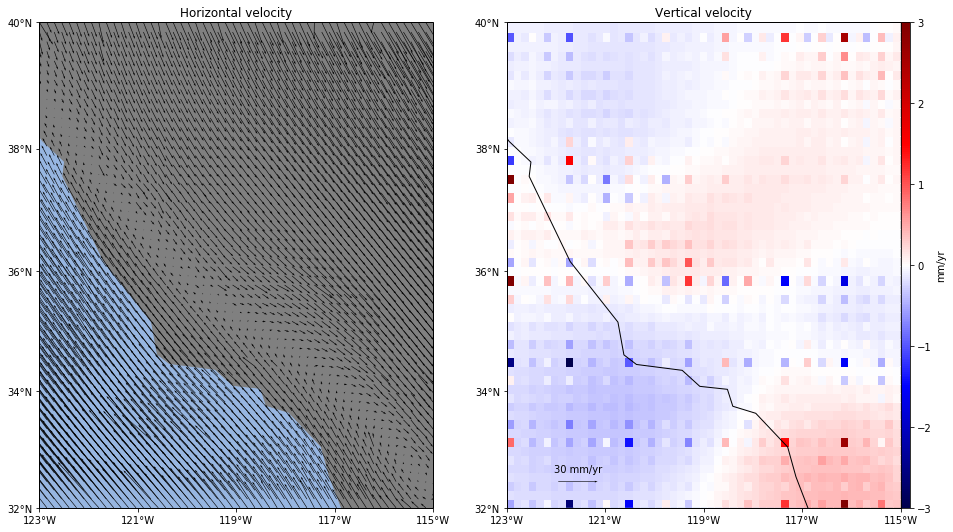

In [22]:
fig, axes = plot_data(grid, every=1)

In [23]:
residuals = make_residuals(chain)
residuals.describe()

,east_velocity,north_velocity,up_velocity,latitude,longitude
count,2809.000000,2809.000000,2809.000000,2809.000000,2809.000000
mean,1.585720,-1.742976,0.018521,36.000000,-119.000000
std,4.774113,5.050320,0.204508,2.309401,2.309401
min,-7.819309,-19.971377,-2.872614,32.075472,-122.924528
25%,-1.215540,-3.678318,-0.056601,34.037736,-120.962264
50%,0.018280,-0.400931,0.008932,36.000000,-119.000000
75%,3.196972,1.264368,0.105073,37.962264,-117.037736
max,18.763313,10.282586,2.615714,39.924528,-115.075472


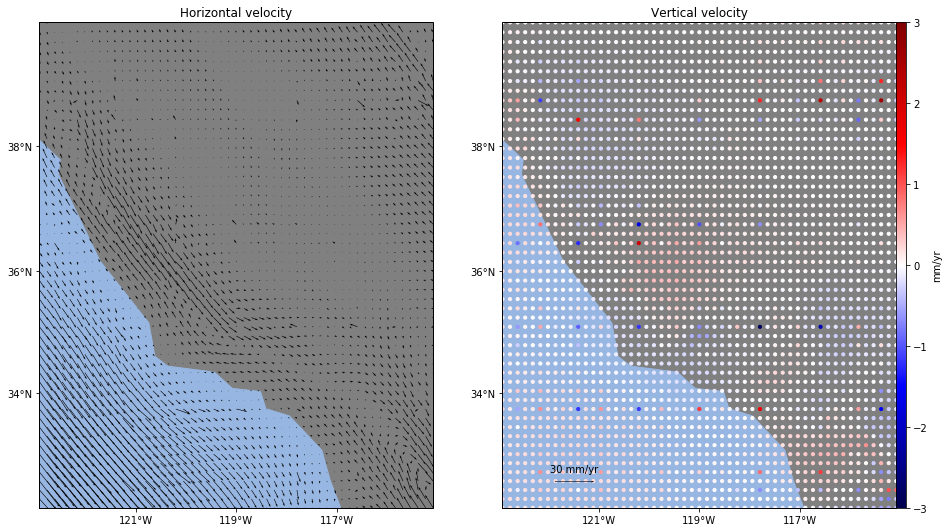

In [24]:
fig, axes = plot_data(residuals, every=1)

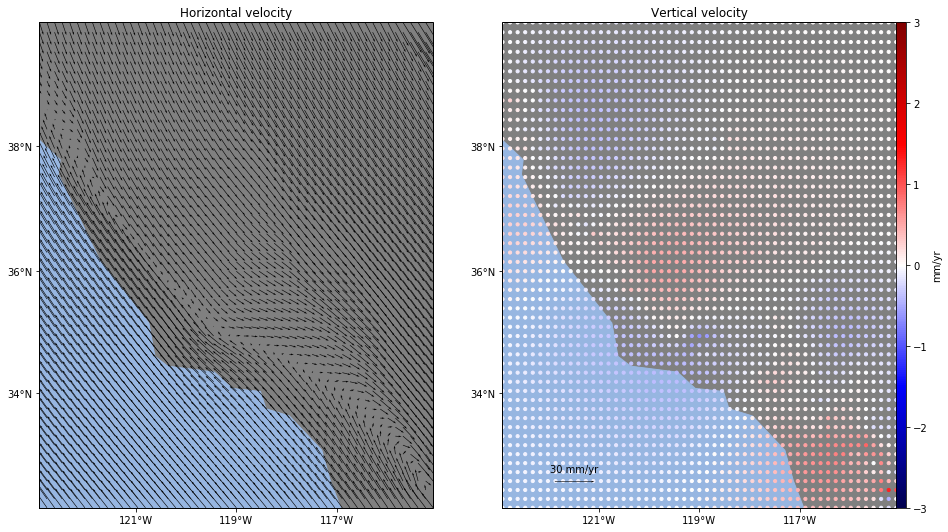

In [25]:
fig, axes = plot_data(reduced, every=1)